<a href="https://colab.research.google.com/github/jonesLevin/TensorFlow-Deep-Learning/blob/main/Transfer_Learning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-18 05:25:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-18 05:25:09 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Check if GPU is available
!nvidia-smi

Tue Apr 18 05:25:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir, unzip_data

## Getting The Data

In [4]:
# Get 10% of training data of food 101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-04-18 05:25:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  41.0MB/s    in 4.6s    

2023-04-18 05:25:19 (34.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [6]:
# Creating training and test directory paths
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [7]:
import tensorflow as tf
from tensorflow import keras

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
DIR_NAME = 'tensorboard'

train_data_10_percent = keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                         image_size=IMAGE_SIZE,
                                                                         batch_size=BATCH_SIZE,
                                                                         label_mode='categorical')

test_data = keras.preprocessing.image_dataset_from_directory(test_dir,
                                                             image_size=IMAGE_SIZE,
                                                             batch_size=BATCH_SIZE,
                                                             label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 0: Feature Extractor Model

In [10]:
# 1. Create the model
base_model = keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model layers
base_model.trainable = False

# 3. Create inputs into the model
inputs = keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. We need to normalize when using as model like Resnet50V2

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

# 6. Average pool the outputs of the base model
x = keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after passing through the global average pooling layer: {x.shape}')

# 7. Create the output activation layer
outputs = keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs and outputs into the model
model_0 = keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after passing through the global average pooling layer: (None, 1280)


In [11]:
# Compile model 0
model_0.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [12]:
# Fit model 0
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name='tensorboard',
                                                               experiment_name='efficientnetb0_feature_extractor')])

Saving TensorBoard log files to: tensorboard/efficientnetb0_feature_extractor/20230418-052529
Epoch 1/5
24/24 [==============================] - 28s 555ms/step - loss: 1.9466 - accuracy: 0.3880 - val_loss: 1.3634 - val_accuracy: 0.6948
Epoch 2/5
24/24 [==============================] - 11s 446ms/step - loss: 1.1159 - accuracy: 0.7813 - val_loss: 0.8976 - val_accuracy: 0.8200
Epoch 3/5
24/24 [==============================] - 8s 304ms/step - loss: 0.7919 - accuracy: 0.8520 - val_loss: 0.7102 - val_accuracy: 0.8420
Epoch 4/5
24/24 [==============================] - 8s 307ms/step - loss: 0.6466 - accuracy: 0.8587 - val_loss: 0.6167 - val_accuracy: 0.8600
Epoch 5/5
24/24 [==============================] - 8s 324ms/step - loss: 0.5462 - accuracy: 0.8760 - val_loss: 0.5619 - val_accuracy: 0.8600


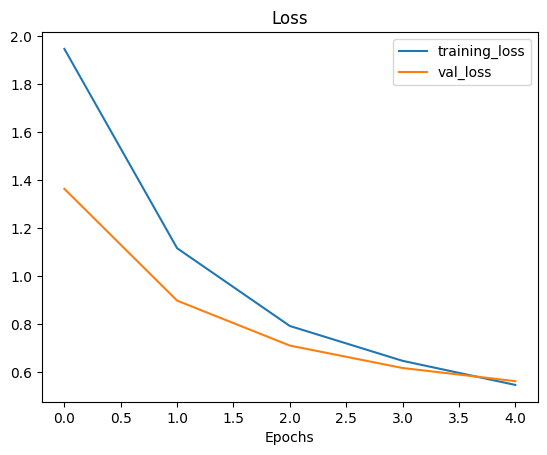

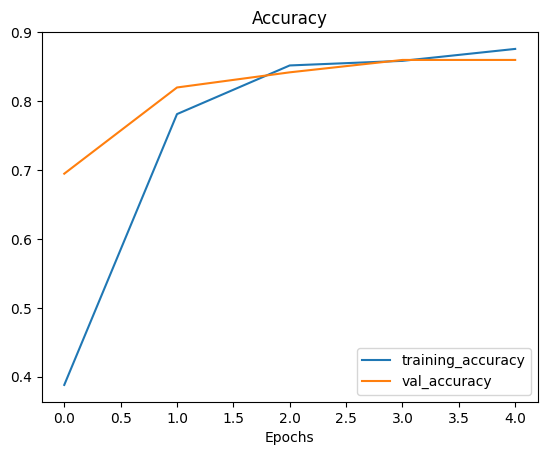

In [13]:
# Plotting the loss curves for model_0
plot_loss_curves(history_0)

In [14]:
# Checking model_0's summary
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Running a Series of Transfer Learning Experiments

### Model 1: Using Feature Extraction On 1% of The Training Data With Data Augmentation

In [15]:
# Getting the data for model 1
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

# Unzip the data
unzip_data('10_food_classes_1_percent.zip')

--2023-04-18 05:26:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 172.217.218.128, 142.251.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  31.8MB/s    in 4.7s    

2023-04-18 05:26:51 (27.1 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [16]:
# Create training and test directories
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [17]:
# Inspect the number of images
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'

In [18]:
# Setup data loaders
train_data_1_percent = keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                        label_mode='categorical',
                                                                        image_size=IMAGE_SIZE,
                                                                        batch_size=BATCH_SIZE)

test_dir = keras.preprocessing.image_dataset_from_directory(test_dir,
                                                            label_mode='categorical',
                                                            image_size=IMAGE_SIZE,
                                                            batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Adding data augmentation into the model

In [19]:
from keras import layers

# Create data augmentation stage
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(.2),
    layers.RandomZoom(.2),
    layers.RandomHeight(.2),
    layers.RandomWidth(.2)
    # layers.Rescaling(1/255.)
], name='data_augmentation')

In [20]:
# Code Fix: augmented_img = data_augmentation(img, training=True)
# Make sure to add above code if images are not augmenting

#### Visualize Data Augmentation

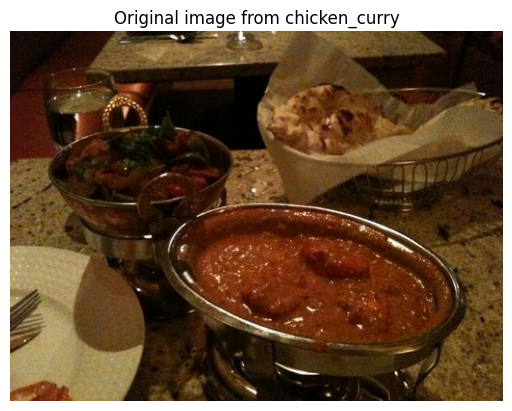

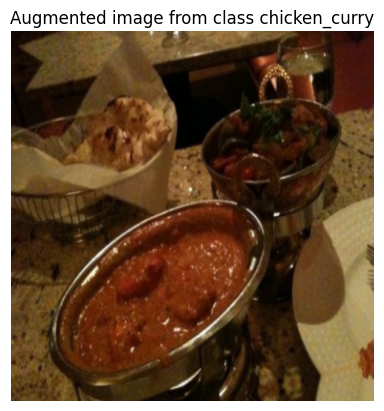

In [21]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))

random_image_path = target_dir + '/' + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original image from {target_class}')
plt.axis(False);

# Now read and plot the augmented version of the image
augmented_img = data_augmentation(img)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title(f'Augmented image from class {target_class}')
plt.axis(False);

#### Building Model 1

In [22]:
# Setup input shape and base model, freezing the base model layers for feature extraction
input_shape = (224, 224, 3)
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add data augentation as a layer
x = data_augmentation(inputs)

# Pass the inputs to the base model and dont train it
x = base_model(x, training=False)

# Pool the output features 
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Add a dense layer as the output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make the model
model_1 = keras.Model(inputs, outputs)

In [23]:
# Compile model 1
model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics='accuracy')

In [24]:
# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback('tensorboard', 
                                                               '1%_data_aug')])

Saving TensorBoard log files to: tensorboard/1%_data_aug/20230418-052657
Epoch 1/5
3/3 [==============================] - 12s 2s/step - loss: 2.3571 - accuracy: 0.1429 - val_loss: 2.2419 - val_accuracy: 0.1727
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1381 - accuracy: 0.2429 - val_loss: 2.1080 - val_accuracy: 0.2451
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9128 - accuracy: 0.4286 - val_loss: 1.9922 - val_accuracy: 0.3438
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7430 - accuracy: 0.6143 - val_loss: 1.8916 - val_accuracy: 0.4243
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.5434 - accuracy: 0.7857 - val_loss: 1.7990 - val_accuracy: 0.4934


In [25]:
# Evaluate on the full dataset
results_model_1 = model_1.evaluate(test_data)
results_model_1

79/79 [==============================] - 6s 65ms/step - loss: 1.7912 - accuracy: 0.4600


[1.7912040948867798, 0.46000000834465027]

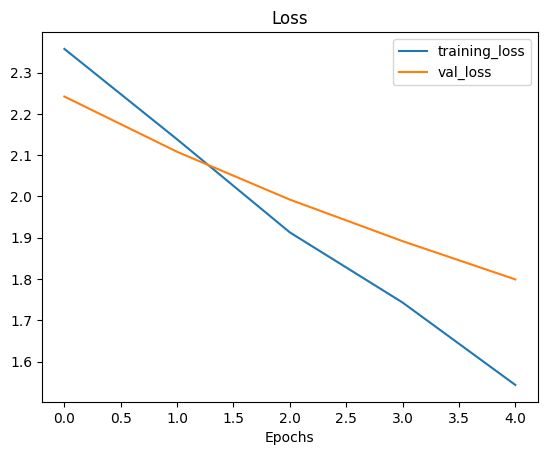

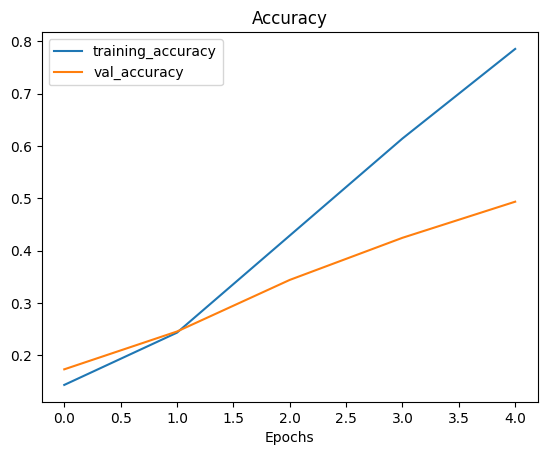

In [26]:
# Check the loss curves of model 1
plot_loss_curves(history_1)

In [27]:
# Check out the model's summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Model 2: Feature Extractor On 10% Of Data Using Data Augmentation

#### Creating a Model Checkpoint Callback

In [28]:
# Set checkpoint path
checkpoint_path = '10_percent_model_checkpoints/checkpoint.ckpt'

# Create a model checkpoint callback that saves the weights only
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      save_freq='epoch',
                                                      verbose=1)

In [29]:
# Getting the feature extractor transfer learning model
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Building the model
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# Fit the model
history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name='tensorboard',
                                                               experiment_name='10%_data_aug_fet_extractor'), 
                                   checkpoint_callback])

Saving TensorBoard log files to: tensorboard/10%_data_aug_fet_extractor/20230418-052744
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9947 - accuracy: 0.3440
Epoch 1: val_loss improved from inf to 1.43293, saving model to 10_percent_model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 22s 640ms/step - loss: 1.9947 - accuracy: 0.3440 - val_loss: 1.4329 - val_accuracy: 0.6760
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3025 - accuracy: 0.6907
Epoch 2: val_loss improved from 1.43293 to 0.99181, saving model to 10_percent_model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 16s 645ms/step - loss: 1.3025 - accuracy: 0.6907 - val_loss: 0.9918 - val_accuracy: 0.7763
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9884 - accuracy: 0.7627
Epoch 3: val_loss improved from 0.99181 to 0.79856, saving model to 10_percent_model_checkpoints/checkpoint.ckpt
24/24 [===========================

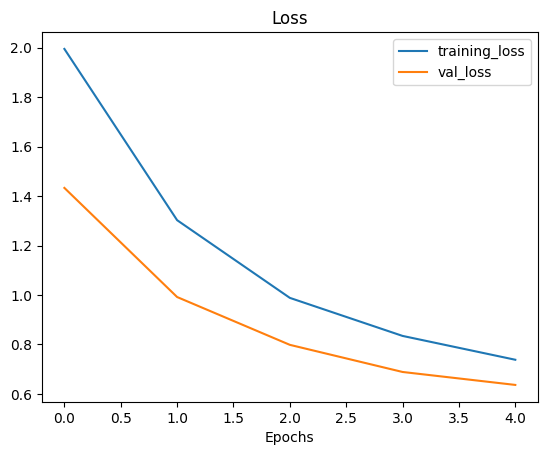

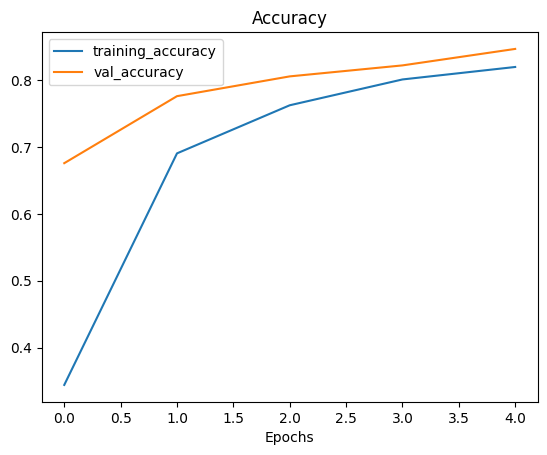

In [30]:
# Checking mode_2 loss curves
plot_loss_curves(history_2)

In [31]:
# Evaluate on full test set
results_model_2 = model_2.evaluate(test_data)
results_model_2

79/79 [==============================] - 6s 66ms/step - loss: 0.6261 - accuracy: 0.8404


[0.6261245012283325, 0.840399980545044]

In [32]:
# Compare model 2 to model 0
model_0.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.5619 - accuracy: 0.8600


[0.5619213581085205, 0.8600000143051147]

#### Loading In Checkpointed Weights 

In [33]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [34]:
# Evaluate model 2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 66ms/step - loss: 0.6261 - accuracy: 0.8404


In [35]:
# If results from previously evaluated model_2 match the loaded weight, everything is ok
results_model_2 == loaded_weights_model_results

False

### Model 3: Fine tuning model 2

In [36]:
# Check model 2 layers
model_2.layers

In [37]:
# Are the layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f62d8271d30> True
<keras.engine.sequential.Sequential object at 0x7f62d851b610> True
<keras.engine.functional.Functional object at 0x7f62bb5ceeb0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f62bb7496a0> True
<keras.layers.core.dense.Dense object at 0x7f62bb46f340> True


In [38]:
# Lets start by unfreezing the last 10 layers of the base model
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile everytime we make a change
model_2.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                metrics='accuracy')

In [39]:
len(model_2.trainable_variables)

12

In [40]:
# Fine tune for another 5 epochs
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

# Refit model_2 with more trainable layers
history_fine_10_percent = model_2.fit(train_data_10_percent,
                                      epochs=fine_tune_epochs,
                                      validation_data=test_data,
                                      validation_steps=int(0.25 * len(test_data)),
                                      initial_epoch=history_2.epoch[-1], # Start training from previous last epoch
                                      callbacks=[create_tensorboard_callback('tensorboard',
                                                                             '10%_fine_tune_last_10')])

Saving TensorBoard log files to: tensorboard/10%_fine_tune_last_10/20230418-052930
Epoch 5/10
24/24 [==============================] - 22s 516ms/step - loss: 0.6095 - accuracy: 0.8347 - val_loss: 0.4960 - val_accuracy: 0.8520
Epoch 6/10
24/24 [==============================] - 11s 448ms/step - loss: 0.4965 - accuracy: 0.8573 - val_loss: 0.4708 - val_accuracy: 0.8602
Epoch 7/10
24/24 [==============================] - 10s 400ms/step - loss: 0.4162 - accuracy: 0.8893 - val_loss: 0.4406 - val_accuracy: 0.8651
Epoch 8/10
24/24 [==============================] - 10s 424ms/step - loss: 0.3861 - accuracy: 0.8987 - val_loss: 0.5020 - val_accuracy: 0.8454
Epoch 9/10
24/24 [==============================] - 10s 404ms/step - loss: 0.3341 - accuracy: 0.8987 - val_loss: 0.4305 - val_accuracy: 0.8668
Epoch 10/10
24/24 [==============================] - 9s 348ms/step - loss: 0.3250 - accuracy: 0.9000 - val_loss: 0.4354 - val_accuracy: 0.8520


In [41]:
# Evaluate fine tuned model on full test data
results_fine_tuned_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.4386 - accuracy: 0.8472


In [42]:
results_model_2

[0.6261245012283325, 0.840399980545044]

In [43]:
# Creating a function to compare training histories
def compare_historys(original, new, initial_epochs=5):
  # Get original history measurements
  acc = original.history['accuracy']
  loss = original.history['loss']

  val_acc = original.history['val_accuracy']
  val_loss = original.history['val_loss']

  # Combined original history
  total_acc = acc + new.history['accuracy']
  total_loss = loss + new.history['loss']

  total_val_acc = val_acc + new.history['val_accuracy']
  total_val_loss = val_loss + new.history['val_loss']

  # Make plot for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Val Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  # Make plot for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Val Loss')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

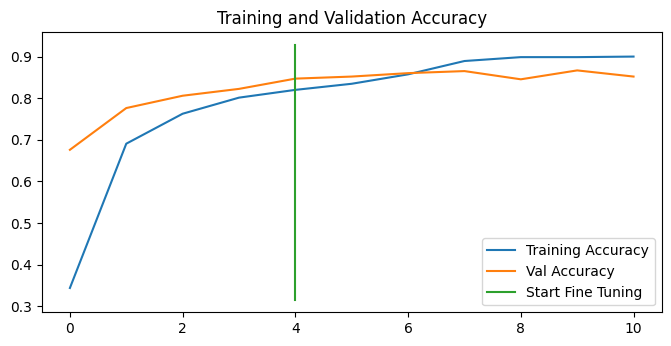

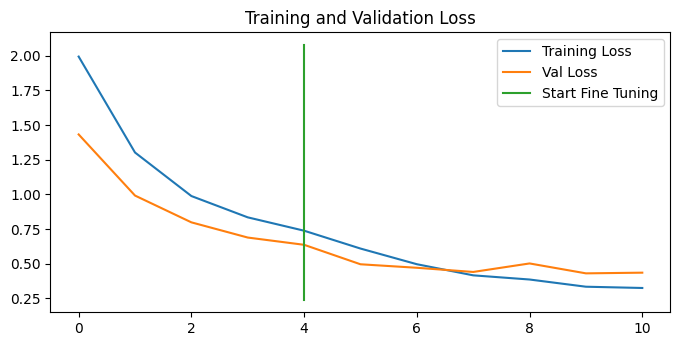

In [44]:
compare_historys(history_2, history_fine_10_percent)

### Model 4: Fine Tuning an Existing Model On all Data

In [45]:
# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data('10_food_classes_all_data.zip')

--2023-04-18 05:49:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.127.128, 142.251.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  20.8MB/s    in 21s     

2023-04-18 05:50:18 (23.6 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [46]:
# Set up training and test dirs
train_dir_all_data = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

In [47]:
# How many images are we working with?
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 

In [48]:
IMAGE_SIZE

(224, 224)

In [49]:
# Setup data inputs
train_data_10_classes_full = keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                              label_mode='categorical',
                                                                              image_size=IMAGE_SIZE)

test_data  = keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode='categorical',
                                                              image_size=IMAGE_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [53]:
# Evaluate model 2 on test data
model_2.evaluate(test_data)

79/79 [==============================] - 7s 81ms/step - loss: 0.6261 - accuracy: 0.8404


[0.626124382019043, 0.840399980545044]

In [54]:
results_fine_tuned_10_percent

[0.438571959733963, 0.8471999764442444]

To train a fine tuning model (model_4), we need to revert model 2 back to its feature extraction weights.
We can do this by loading the model from checkpoint

In [52]:
# Load weights from checkpoint to fine tune from same stage
model_2.load_weights(checkpoint_path)

ValueError: ignored

In [55]:
# Lets evaluate model 2 now
model_2.evaluate(test_data)

79/79 [==============================] - 7s 69ms/step - loss: 0.6261 - accuracy: 0.8404


[0.6261244416236877, 0.840399980545044]

In [56]:
# Check if model has been reverted back to feature extractor results
results_model_2

[0.6261245012283325, 0.840399980545044]

In [57]:
# Check which layers in model 2 are trainable
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [59]:
# Check what layers are trainable in base model
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [60]:
# Compile 
model_2.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                metrics='accuracy')

In [61]:
# Continue to train and fine tune the model on the whole data
fine_tune_epochs = initial_epochs + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(.25 * len(test_data)),
                                           initial_epoch=history_2.epoch[-1],
                                           callbacks=[create_tensorboard_callback('tensorboard',
                                                                                  'full_10_classes_fine_tune_last_10')])

Saving TensorBoard log files to: tensorboard/full_10_classes_fine_tune_last_10/20230418-062437
Epoch 5/10
235/235 [==============================] - 77s 280ms/step - loss: 0.6461 - accuracy: 0.7956 - val_loss: 0.3355 - val_accuracy: 0.8964
Epoch 6/10
235/235 [==============================] - 57s 242ms/step - loss: 0.5225 - accuracy: 0.8288 - val_loss: 0.2977 - val_accuracy: 0.8964
Epoch 7/10
235/235 [==============================] - 54s 224ms/step - loss: 0.4528 - accuracy: 0.8541 - val_loss: 0.2732 - val_accuracy: 0.9095
Epoch 8/10
235/235 [==============================] - 51s 216ms/step - loss: 0.4216 - accuracy: 0.8615 - val_loss: 0.2713 - val_accuracy: 0.9145
Epoch 9/10
235/235 [==============================] - 49s 207ms/step - loss: 0.3815 - accuracy: 0.8733 - val_loss: 0.2499 - val_accuracy: 0.9145
Epoch 10/10
235/235 [==============================] - 43s 182ms/step - loss: 0.3435 - accuracy: 0.8901 - val_loss: 0.2561 - val_accuracy: 0.9095


In [62]:
# Evaluate on the whole test data
results_fine_tune_full = model_2.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.2733 - accuracy: 0.9076


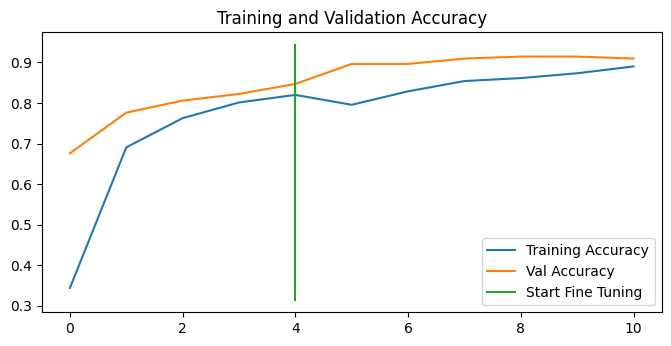

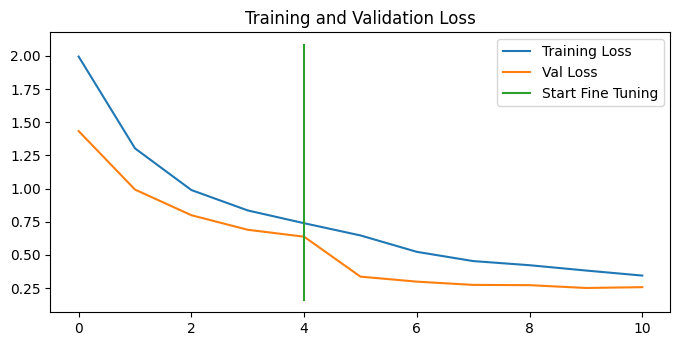

In [63]:
# Compare historys
compare_historys(history_2, history_fine_10_classes_full)

## Viewing Our Experiments On Tensorboard

In [ ]:
# View tensorboard logs and upload tensorboard dev records
!tensorboard dev upload --logdir ./tensorboard \
  --name "Transfer Learning Experiments with 10 Food 101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot

My tensorboard experiments are available at: https://tensorboard.dev/experiment/Q9vi0iMFR7C6RG1xCG1Gew/